In [5]:
#use wdtools_env_pip environment

import numpy as np
from math import log10, floor
from bisect import bisect_left
from scipy import stats
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
plt.style.use('Software/stefan.mplstyle')

import pandas as pd
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'

#for machine learning
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import load_model


# This notebook combined the final heatmap plots from previous 05 notebooks into one final figure for the paper

### Define functions

In [6]:
def get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,sample_type):
    #read back in measurements
    noise_label="".join(noise_effect_array)
    
    #sample_type='training','testing', or 'bootstrap'
    if sample_type=='training':
        #read back in measurements
        npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/training_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
        med_abs_deviations = npzfile['med_abs_deviations']
        
    if sample_type=='testing':
        #read back in measurements
        npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/testing_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
        med_abs_deviations = npzfile['med_abs_deviations']

    Ws = npzfile['Ws']
    final_distances = npzfile['distances']
    moransIs = npzfile['moransIs'] 
    expectations = npzfile['expectations']
    variances = npzfile['variances']
    zscores = npzfile['zscores']
    
    mult=[]
    for i in range(len(moransIs)):
        mult.append(moransIs[i]*zscores[i])

    return(final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult)


In [7]:
def test_model(model, noise_effect_array, improvement_factor, effect_strength, chance_companion,
               remove_likely_binaries):
    
    sample_size=10207
    
    #for training data
    corr_lengths=np.round(np.append(np.linspace(1,98,30)[1:],np.logspace(2,3,num=100)[1:-1]),2)
    def round_sig(x,sig):
        return round(x, sig-int(floor(log10(abs(x))))-1)
    epsilons_init=np.append(np.logspace(-10,-1,num=20),np.linspace(0.1,0.5,4)[1:])
    epsilons=[]
    for e in epsilons_init:
        epsilons.append(round_sig(e,2))
    #turn into combined simulation parameter array
    simulation_params=[]
    for corr_length in corr_lengths:
        for epsilon in epsilons:
            simulation_params.append([corr_length,epsilon])

    #for testing data
    corr_lengths_testing=[10,25,50,75,100,150,200,250,300,400,500,600,700,800,900,1000]
    epsilons_testing=[1e-10,1e-7,1e-4,0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
    #turn into combined simulation parameter array
    simulation_params_testing=[]
    for corr_length in corr_lengths_testing:
        for epsilon in epsilons_testing:
            simulation_params_testing.append([corr_length,epsilon])
    
    x_train=[]
    y_train=[]
    ep_train=[]
    for simulation in simulation_params:
        corr_length=simulation[0]
        epsilon=simulation[1]
        final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                              remove_likely_binaries,'training')
        #Normalize then save Moran's I x Z-Score curve as 1D training data
        normalized=mult/np.nanmax(np.abs(mult))
        x_train.append(normalized)
        #save correlation length as true label
        y_train.append(corr_length)
        #also save epsilon
        ep_train.append(epsilon)
    x_train=np.array(x_train)
    y_train=np.array(y_train)
    ep_train=np.array(ep_train)
    #there are NaNs in the data set from the d = 1pc cut having no WDs at that separation, set these NaNs to 0
    x_train=np.nan_to_num(x_train)
    training_data=pd.DataFrame()
    training_data['y_true']=y_train
    training_data['epsilon']=ep_train
    
    x_test=[]
    y_test=[]
    ep_test=[]
    for simulation in simulation_params_testing:
        corr_length=simulation[0]
        epsilon=simulation[1]
        final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                              remove_likely_binaries,'testing')
        #Normalize then save Moran's I x Z-Score curve as 1D training data
        normalized=mult/np.nanmax(np.abs(mult))
        x_test.append(normalized)
        #save correlation length as true label
        y_test.append(corr_length)
        #also save epsilon
        ep_test.append(epsilon)  
    x_test=np.array(x_test)
    y_test=np.array(y_test)
    ep_test=np.array(ep_test)
    #there are NaNs in the data set from the d = 1pc cut having no WDs at that separation, set these NaNs to 0
    x_test=np.nan_to_num(x_test)
    testing_data=pd.DataFrame()
    testing_data['y_true']=y_test
    testing_data['epsilon']=ep_test

    # use the model to predict the training data
    y_pred_train = model.predict(x_train, verbose=0)
    training_data['y_pred']=y_pred_train
    
    # use the model to predict the testing data
    y_pred_test = model.predict(x_test, verbose=0)
    testing_data['y_pred']=y_pred_test
    
    training_data['abs_frac_err']=np.abs((training_data['y_true']-training_data['y_pred'])/training_data['y_true'])
    testing_data['abs_frac_err']=np.abs((testing_data['y_true']-testing_data['y_pred'])/testing_data['y_true'])

    return(training_data,testing_data)


In [8]:
#define a function to create the heatmap
def heatmap(data, row_labels, col_labels, ax=None):
    if not ax:
        ax = plt.gca()
        
    # Define color map with custom gradients
    cmap = plt.cm.viridis  # Default, replace with any colormap of your choice
    # Define boundaries for the color ranges
    boundaries = [0, 2, 4, 6, 8, 10, 1000]
    # Define colors corresponding to each range (make sure this matches the number of ranges)
    colors_for_ranges = [
    '#228B22',  # Forest Green
    '#32CD32',  # Lime Green
    '#FFD700',  # Gold (Yellow)
    '#FFA500',  # Orange
    '#FF4500',  # Orange Red
    '#DC143C',  # Crimson
    'black']
    # Create a ListedColormap and BoundaryNorm
    cmap = pltcolors.ListedColormap(colors_for_ranges)
    norm = pltcolors.BoundaryNorm(boundaries, cmap.N)
    
    # Plot the heatmap
    im = ax.imshow(data, cmap=cmap, norm=norm)
    
    #label rows/columns
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels)#, fontsize=10)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels)
    
    #draw grid lines
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="k", linestyle='-', linewidth=0.5,alpha=0.3)
    ax.tick_params(which="minor", bottom=False, left=False,top=False, right=False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    return im

def heatmap_testing_data(testing_data,figtitle=None,savefig=False,figname=None):
    #for testing data
    corr_lengths_testing=[10,25,50,75,100,150,200,250,300,400,500,600,700,800,900,1000]
    epsilons_testing=[1e-10,1e-7,1e-4,0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
    
    data=[]
    failed_fit_region_count=0
    for corr_len in corr_lengths_testing:
        tmp=[]
        for epsilon in epsilons_testing:
            val=testing_data.query('y_true==@corr_len & epsilon==@epsilon')['abs_frac_err'].to_list()[0]*100
            tmp.append(val)
            if val>10:
                failed_fit_region_count+=1
        data.append(tmp)
    data=np.array(data)
    
    fig,ax0=plt.subplots(1, 1, figsize=(10, 10))
    ylabels=[str(i) for i in corr_lengths_testing]
    xlabels=[str(i) for i in epsilons_testing]
    hm=heatmap(data, ylabels, xlabels, ax=ax0)
    ax0.set_xlabel('$\epsilon$')
    ax0.set_ylabel('$\Delta x_{true}$')
    
    ax0.set_title(figtitle)
    
    #plot colorbar
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
    fig.colorbar(hm, cbar_ax)
    cbar_ax.set_ylabel("Absolute Percent Error")#,fontsize=16)
    
    if savefig:
        plt.savefig(figname+'.pdf', dpi=300)
        
    plt.show()
    print('Number of squares with abs percent err>10%, ', failed_fit_region_count)
    
    return(failed_fit_region_count)

### Make Plot

In [9]:
testing_data_dict={}

nb='00'
noise_effect_array=['0','0','0','0','0']
improvement_factor=1
effect_strength=1
chance_companion=0.01
remove_likely_binaries='0'
model = load_model('csv/nb05_sample_size_10207/'+nb+'_final_model')
training_data00,testing_data_dict['00']=test_model(model, noise_effect_array, improvement_factor, effect_strength, chance_companion,
               remove_likely_binaries)

nb='01'
noise_effect_array=['1','0','0','0','0']
improvement_factor=1
effect_strength=1
chance_companion=0.01
remove_likely_binaries='0'
model = load_model('csv/nb05_sample_size_10207/'+nb+'_final_model')
training_data01,testing_data_dict['01']=test_model(model, noise_effect_array, improvement_factor, effect_strength, chance_companion,
               remove_likely_binaries)

nb='03'
noise_effect_array=['0','1','0','0','0']
improvement_factor=1
effect_strength=10
chance_companion=0.01
remove_likely_binaries='0'
model = load_model('csv/nb05_sample_size_10207/'+nb+'_final_model')
training_data03,testing_data_dict['03']=test_model(model, noise_effect_array, improvement_factor, effect_strength, chance_companion,
               remove_likely_binaries)

nb='04'
noise_effect_array=['0','0','1','0','0']
improvement_factor=1
effect_strength=1
chance_companion=0.01
remove_likely_binaries='1'
model = load_model('csv/nb05_sample_size_10207/'+nb+'_final_model')
training_data04,testing_data_dict['04']=test_model(model, noise_effect_array, improvement_factor, effect_strength, chance_companion,
               remove_likely_binaries)

nb='06'
noise_effect_array=['0','0','0','1','0']
improvement_factor=10
effect_strength=1
chance_companion=0.01
remove_likely_binaries='0'
model = load_model('csv/nb05_sample_size_10207/'+nb+'_final_model')
training_data06,testing_data_dict['06']=test_model(model, noise_effect_array, improvement_factor, effect_strength, chance_companion,
               remove_likely_binaries)

nb='07'
noise_effect_array=['0','0','0','0','1']
improvement_factor=1
effect_strength=1
chance_companion=0.01
remove_likely_binaries='0'
model = load_model('csv/nb05_sample_size_10207/'+nb+'_final_model')
training_data07,testing_data_dict['07']=test_model(model, noise_effect_array, improvement_factor, effect_strength, chance_companion,
               remove_likely_binaries)

nb='11'
noise_effect_array=['1','1','1','1','1']
improvement_factor=10
effect_strength=10
chance_companion=0.01
remove_likely_binaries='1'
model = load_model('csv/nb05_sample_size_10207/'+nb+'_final_model')
training_data11,testing_data_dict['11']=test_model(model, noise_effect_array, improvement_factor, effect_strength, chance_companion,
               remove_likely_binaries)


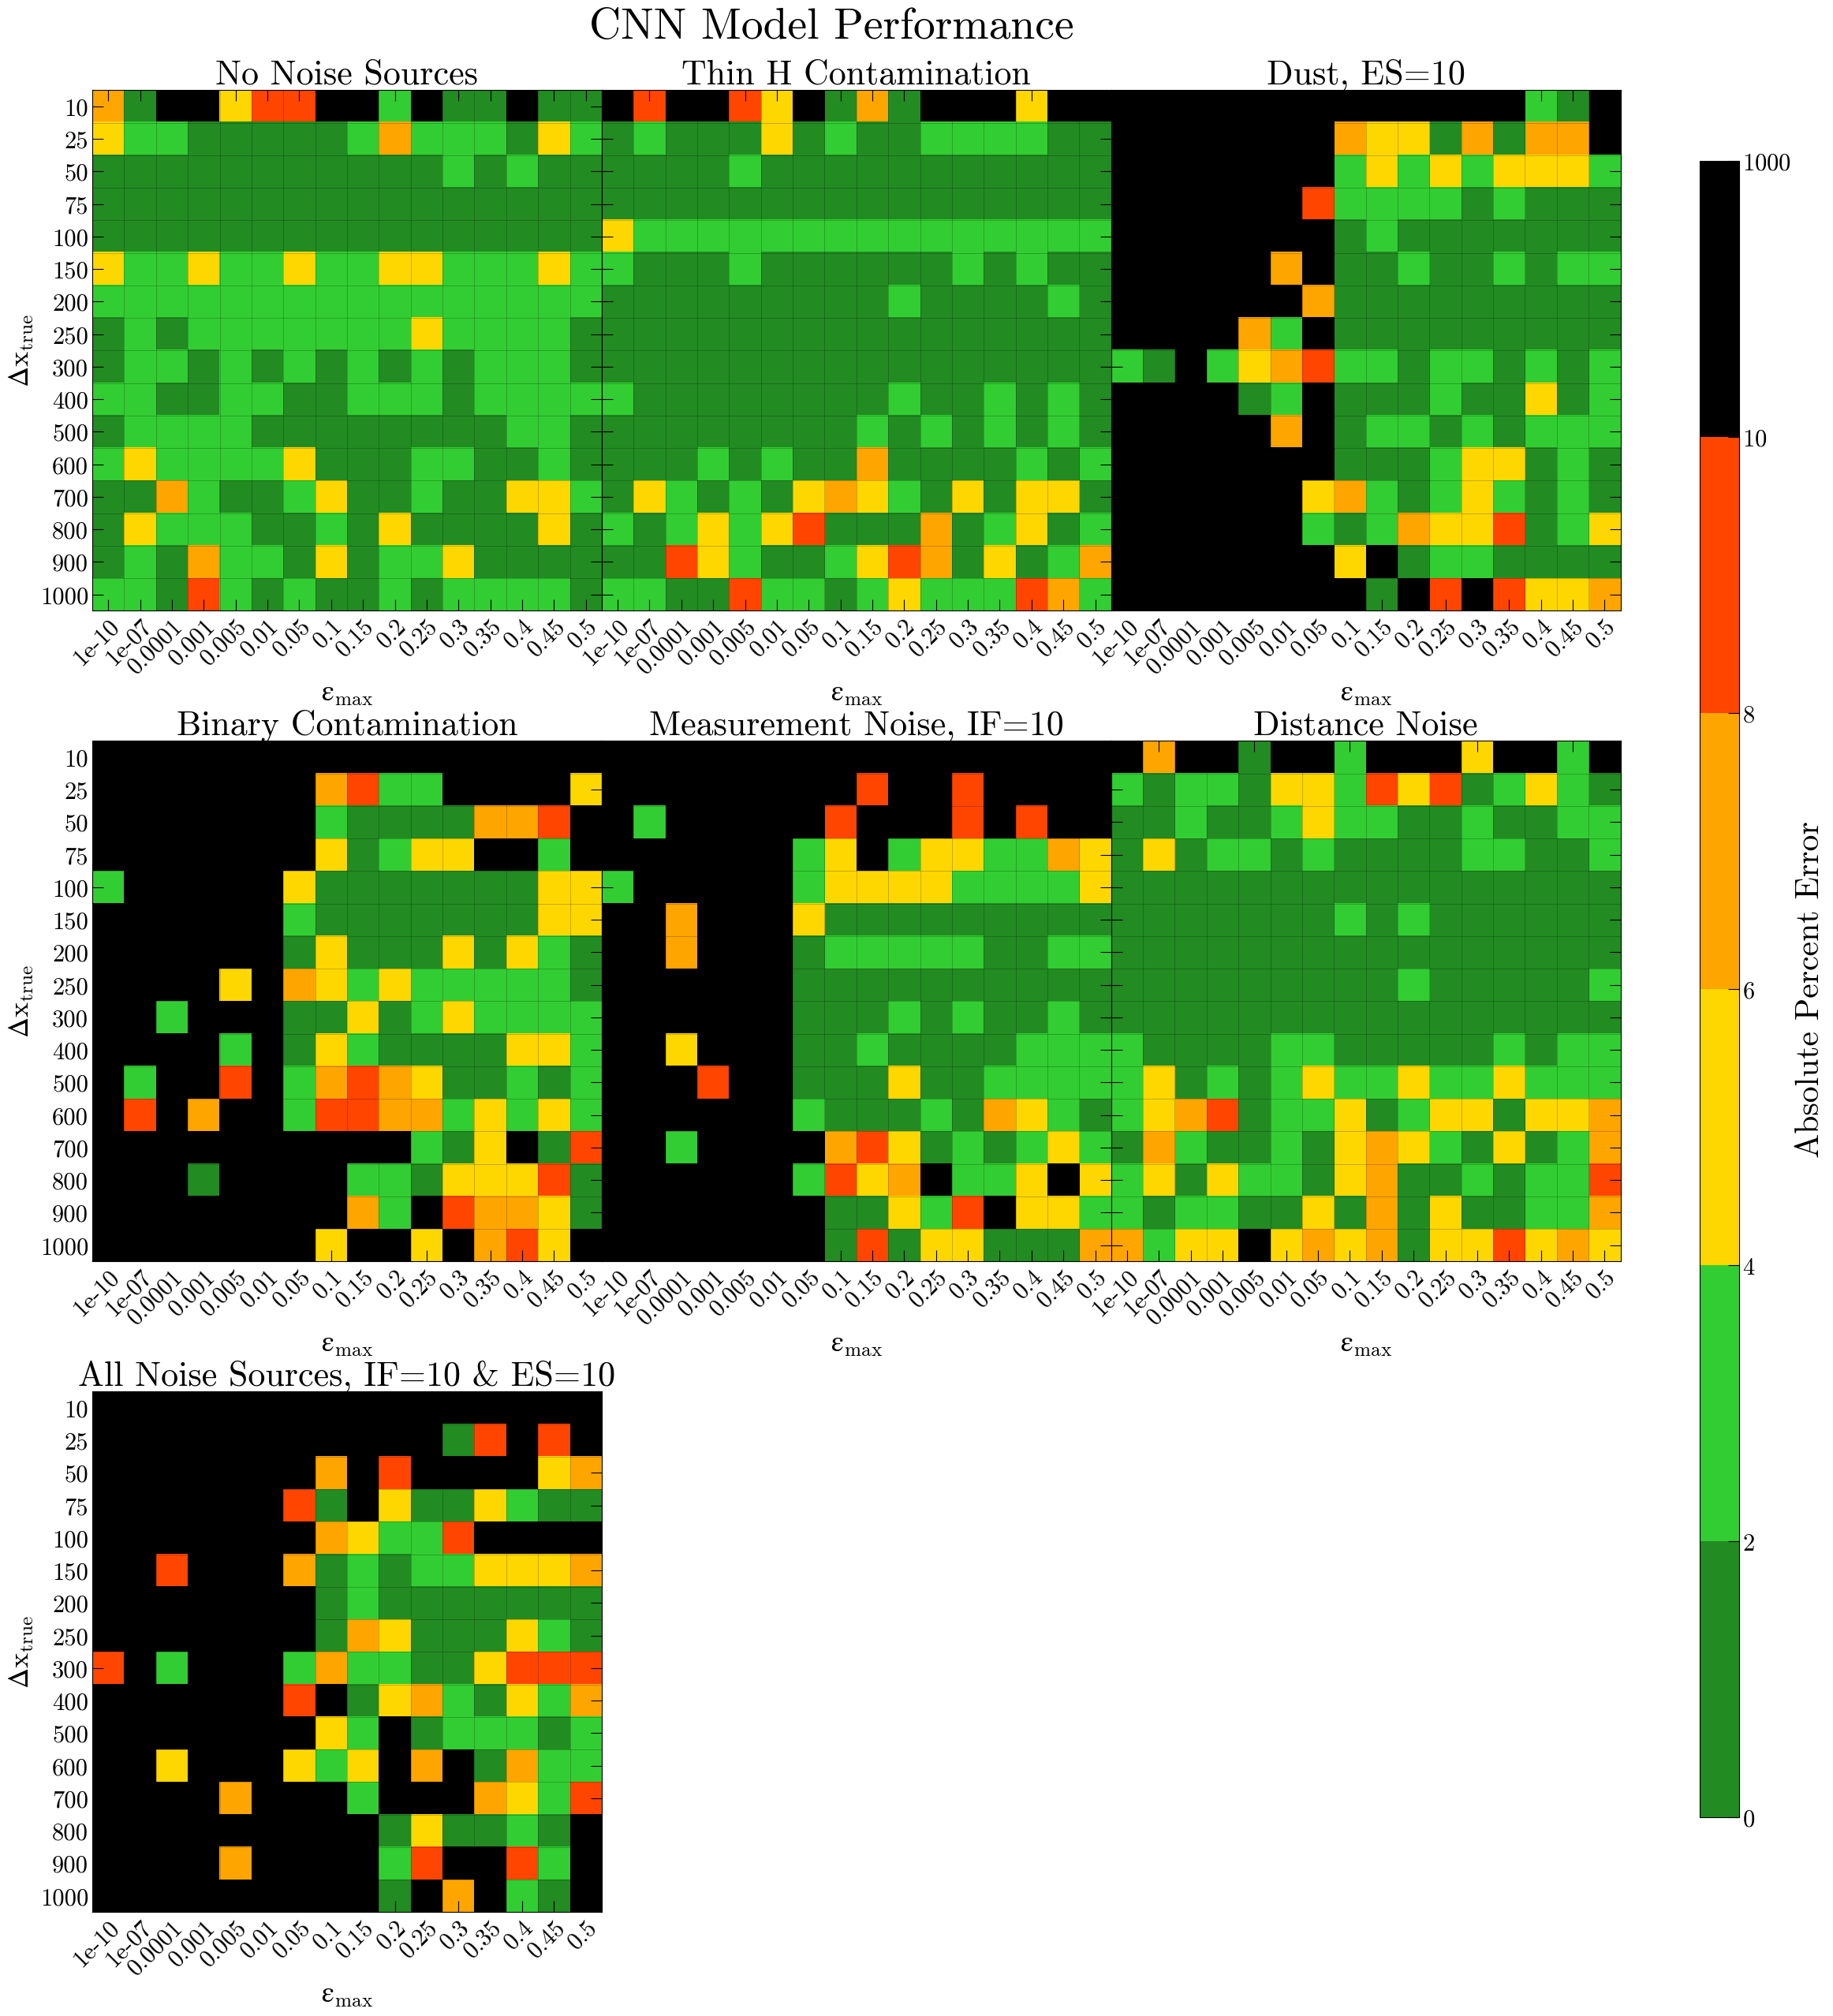

In [12]:
corr_lengths_testing=[10,25,50,75,100,150,200,250,300,400,500,600,700,800,900,1000]
epsilons_testing=[1e-10,1e-7,1e-4,0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
#fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8))=plt.subplots(4,2, figsize=(20, 45),sharey=True)
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9))=plt.subplots(3,3, figsize=(25,30),sharey=True)

notebooks=['00','01','03','04','06','07','11']
axs=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
titles=['No Noise Sources','Thin H Contamination','Dust, ES=10',
       'Binary Contamination','Measurement Noise, IF=10',
       'Distance Noise','All Noise Sources, IF=10 & ES=10']

for i in range(len(notebooks)):
    nb=notebooks[i]
    ax=axs[i]
    testing_data=testing_data_dict[nb]
    data=[]
    for corr_len in corr_lengths_testing:
        tmp=[]
        for epsilon in epsilons_testing:
            val=testing_data.query('y_true==@corr_len & epsilon==@epsilon')['abs_frac_err'].to_list()[0]*100
            tmp.append(val)
        data.append(tmp)
    data=np.array(data)
    
    ylabels=[str(i) for i in corr_lengths_testing]
    xlabels=[str(i) for i in epsilons_testing]
    hm=heatmap(data, ylabels, xlabels, ax=ax)
    ax.set_xlabel('$\epsilon_{max}$')
    if ax in [ax1,ax4,ax7]:
        ax.set_ylabel('$\Delta x_{true}$')
    ax.set_title(titles[i])

ax8.axis("off")
ax9.axis("off")

plt.subplots_adjust(wspace = 0,hspace=0.25)

fig.suptitle('CNN Model Performance',y=0.915,fontsize=40)

#plot colorbar
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
fig.colorbar(hm, cbar_ax)
cbar_ax.set_ylabel("Absolute Percent Error",fontsize=30)

plt.savefig('CNN_model_performance.pdf', dpi=300)#, pad_inches=0.3)